<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Sentinel_model_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install progressbar2

In [0]:
!pip install dask-image

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
  Created wheel for dask-image: filename=dask_image-0.2.0-py2.py3-none-any.whl size=22056 sha256=0f34ffc68f16ce8a040cef900ddcd2356e0acf5de88c30c49c2ca388149ab2c4
  Stored in directory: /root/.cache/pip/wheels/9c/0d/46/22f406c3bff35ad80a7d6785f96fb3381114e97d3cd3615f63
Successfully built dask-image


In [0]:
# Load Dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
from shapely.geometry import Polygon # vector geometries
import rasterio as rio # raster spatial operations
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import os
import time
import progressbar
import matplotlib.pyplot as plt
#import dask_image.imread
#import dask_image.ndfilters
#import dask_image.ndmeasure
#import dask.array as da

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Functions
credit to # https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [0]:
# returns matrix of [n ships, patch_size, patch_size]
def create_ship_patches(ships, img, patch_size=30):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      patch = img.read(window=window) # clip is a nbands * patch_size * patch_size numpy array
      patch_list[i] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
      bar.update(i)
  return patch_list.astype(int)

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  patches = np.zeros([n_patches, patch_size, patch_size, len(img.indexes)])
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array
          patches[index] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  return patches.astype(int)


In [0]:
# create X and dataframe with labels
def patch_intersects_ship(ships, img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  X = np.zeros([n_patches, patch_size, patch_size, len(img.indexes)])
  isShip_list = [] #list to hold all the patch locations
  x_list = []
  y_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array
          X[index] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
          # create polygon with patches spatial coordinates
          patch_poly = Polygon([img.transform * (window.col_off, window.row_off), #must be a more pythonic way to do this
                              img.transform * (window.col_off + window.width, window.row_off),
                              img.transform * (window.col_off + window.width, window.row_off + window.height),
                              img.transform * (window.col_off, window.row_off + window.height)])
          isShip = np.any(ships.intersects(patch_poly)) #intersect ships with polygon and chek if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results, X

In [0]:
# create X and y
def patch_intersects_ship(ships, img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  X = np.zeros([n_patches, patch_size, patch_size, len(img.indexes)])
  y = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array
          X[index] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
          # create polygon with patches spatial coordinates
          patch_poly = Polygon([img.transform * (window.col_off, window.row_off), #must be a more pythonic way to do this
                              img.transform * (window.col_off + window.width, window.row_off),
                              img.transform * (window.col_off + window.width, window.row_off + window.height),
                              img.transform * (window.col_off, window.row_off + window.height)])
          isShip = np.any(ships.intersects(patch_poly)) #intersect ships with polygon and chek if any are positive
          y.append(isShip)
          index += 1
          bar.update(index)
  
  return X, y

In [0]:
# create X
def patch_intersects_ship(ships, img, patch_size=50, step_size=25):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  X = np.zeros([n_patches, patch_size, patch_size, len(img.indexes)])
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array
          X[index] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  
  return X

In [0]:
# create y
def patch_intersects_shipy(ships, img, patch_size=50, step_size=25):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  y_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # create polygon with patches spatial coordinates
          patch_poly = Polygon([img.transform * (window.col_off, window.row_off), #must be a more pythonic way to do this
                              img.transform * (window.col_off + window.width, window.row_off),
                              img.transform * (window.col_off + window.width, window.row_off + window.height),
                              img.transform * (window.col_off, window.row_off + window.height)])
          isShip = np.any(ships.intersects(patch_poly)) #intersect ships with polygon and chek if any are positive
          y_list.append(isShip),
          index += 1
          bar.update(index)
  
  return y_list

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship(ships, img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  isShip_list = [] #list to hold all the patch locations
  x_list = []
  y_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # create polygon with patches spatial coordinates
          patch_poly = Polygon([img.transform * (window.col_off, window.row_off), #must be a more pythonic way to do this
                              img.transform * (window.col_off + window.width, window.row_off),
                              img.transform * (window.col_off + window.width, window.row_off + window.height),
                              img.transform * (window.col_off, window.row_off + window.height)])
          isShip = np.any(ships.intersects(patch_poly)) #intersect ships with polygon and chek if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

# Testing

In [8]:
drive_path = '/content/drive/My Drive/MUSA-650-Final-Project/'
# NOTE: unified notebook will be able to use the title field from sceneMeta to get specific images and ship points
files = os.listdir(drive_path)
files

['S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2',
 'S2B_MSIL1C_20171122T032029_N0206_R118_T48NUG_20200423T142704.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323_SHIPS.geojson',
 'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031_SHIPS.geojson',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_SHIPS.geojson',
 'S2B_MSIL1C_20171122T032029_N0206_R118_T48NUG_20200423T142704_SHIPS.geojson']

In [0]:
# load ship points
ship_points = gpd.read_file('/content/drive/My Drive/MUSA-650-Final-Project/S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_SHIPS.geojson')

In [0]:
# load satelite image
sat_img = rio.open('/content/drive/My Drive/MUSA-650-Final-Project/S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2')

In [0]:
# this function takes a few minutes to run
X, y = patch_intersects_ship(ships=ship_points, img=sat_img)

In [29]:
# this function takes a few minutes to run
y = patch_intersects_shipy(ships=ship_points, img=sat_img)

100% (193600 of 193600) |################| Elapsed Time: 0:05:34 Time:  0:05:34


In [0]:
X.shape

(133956, 50, 50, 3)

In [31]:
y = np.asarray(y, dtype=int)
y.shape

(191844,)

In [0]:
test_class.isShip.unique()
test_class

,isShip,x,y,patch_size
0,False,0,0,50
1,False,30,0,50
2,False,60,0,50
3,False,90,0,50
4,False,120,0,50
...,...,...,...,...
133220,False,10800,10920,50
133221,False,10830,10920,50
133222,False,10860,10920,50
133223,False,10890,10920,50


In [0]:
Ship =  test_class['isShip']==True
test_class_Ship = test_class[Ship]
test_class_Ship.shape

(1060, 4)

In [0]:
index = []

for row in test_class.iterrows():
  if ['isShip']==True:
    index.append(1)
  else:
    index.append(0)

In [0]:
len(index)

133225

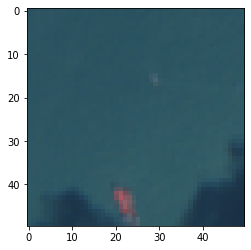

In [0]:
test_ships = test_class.loc[test_class.isShip == True]
i = 90
test_w = rio.windows.Window(test_ships.iloc[i].x,test_ships.iloc[i].y, test_ships.iloc[i].patch_size, test_ships.iloc[i].patch_size)
test_patch = sat_img.read(window=test_w)
show(test_patch)

In [0]:
training_ship_patches = create_ship_patches(ship_points, sat_img)

100% (425 of 425) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


In [0]:
training_ship_patches.shape

(425, 30, 30, 3)

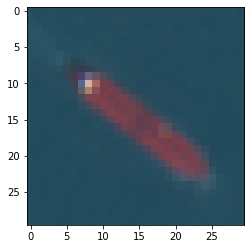

In [0]:
#plot ship patch
plt.imshow(training_ship_patches[10])

In [0]:
test_patches = create_patches(sat_img)

100% (133956 of 133956) |################| Elapsed Time: 0:00:49 Time:  0:00:49


In [0]:
test_patches.shape

(133956, 50, 50, 3)

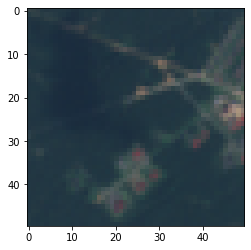

In [0]:
plt.imshow(test_patches[5567])

In [0]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation

M5 = Sequential()
M5.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
M5.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2))) #32x32
M5.add(Dropout(0.25))

M5.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2))) #16x16

M5.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2))) #8x8

M5.add(Dropout(0.25))
M5.add(Flatten())

M5.add(Dense(1024, activation='relu'))
M5.add(Dropout(0.25))
M5.add(Dense(4096, activation='relu'))
M5.add(Dense(10, activation='softmax'))

In [0]:
M5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 512)      

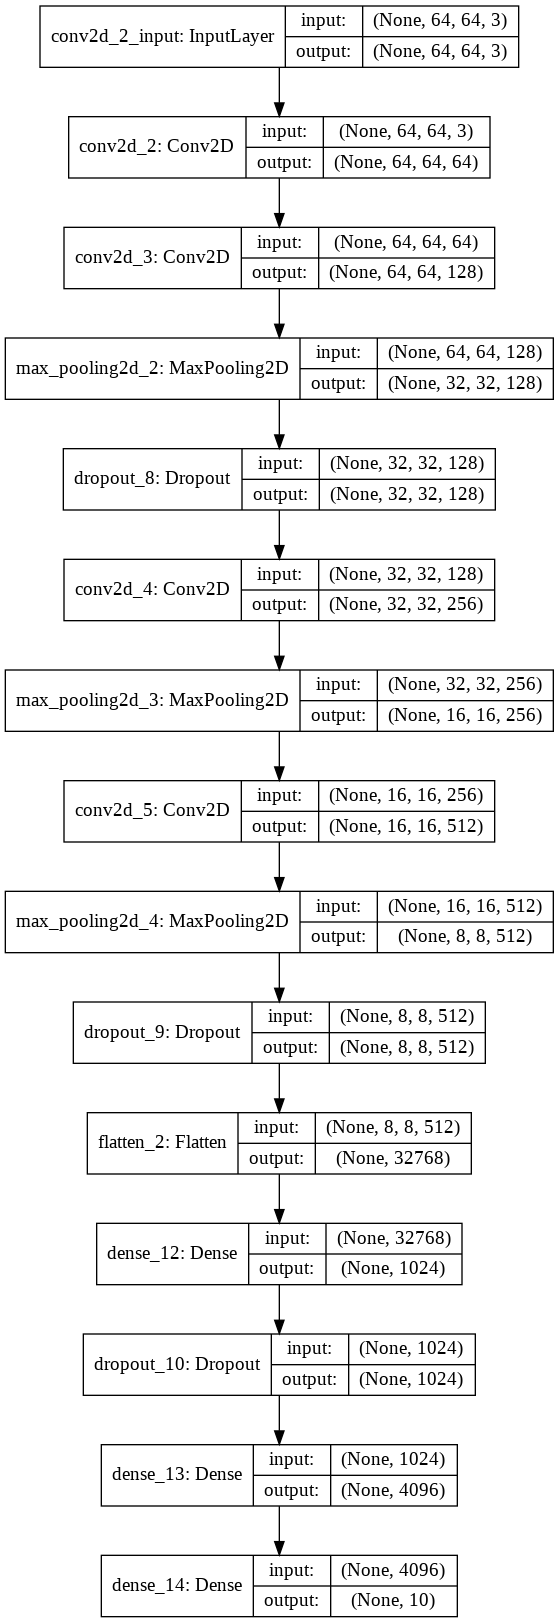

In [0]:
plot_model(M5, show_shapes=True, show_layer_names=True)

In [0]:
M5.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X2_train,
    y2_train,
    batch_size=250,
    )

validation_generator = test_datagen.flow(
    X2_test,
    y2_test,
    batch_size=250,
    )

M5.fit_generator(
    train_generator,
    steps_per_epoch=len(X2_train) // 250,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(X2_test) // 250)

Epoch 1/25
54/54 [==============================] - 22s 409ms/step - loss: 4.1449 - accuracy: 0.1856 - val_loss: 2.0245 - val_accuracy: 0.2852
Epoch 2/25
54/54 [==============================] - 20s 362ms/step - loss: 2.0791 - accuracy: 0.2253 - val_loss: 2.0083 - val_accuracy: 0.2001
Epoch 3/25
54/54 [==============================] - 20s 364ms/step - loss: 1.8877 - accuracy: 0.2674 - val_loss: 1.7712 - val_accuracy: 0.2873
Epoch 4/25
54/54 [==============================] - 19s 361ms/step - loss: 1.7430 - accuracy: 0.3344 - val_loss: 1.9235 - val_accuracy: 0.3127
Epoch 5/25
54/54 [==============================] - 19s 360ms/step - loss: 1.6175 - accuracy: 0.3834 - val_loss: 1.6755 - val_accuracy: 0.3759
Epoch 6/25
54/54 [==============================] - 20s 362ms/step - loss: 1.4303 - accuracy: 0.4804 - val_loss: 1.1356 - val_accuracy: 0.5778
Epoch 7/25
54/54 [==============================] - 19s 359ms/step - loss: 1.3229 - accuracy: 0.5276 - val_loss: 0.9657 - val_accuracy: 0.6403

In [0]:
#Evaluating test loss and test accuracy
score = M5.evaluate(X2_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4371580673500344
Test accuracy: 0.8566666841506958
